In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from get_abundance import get_otu_count, _agg_along_axis, _taxa_qc

In [1]:
data_dir = "/mnt/c/aws_data/20240122_logan_tyndall_fabric_interaction_reanalysis"
zotu_taxon_path = f"{data_dir}/output_unoise3_{{}}/unoise3_zotu_rrndb_processed.tsv"
otu_count_path = f"{data_dir}/output_unoise3_{{}}/unoise3_zotu.tsv"
zotu_fasta_path = f"{data_dir}/output_unoise3_{{}}/unoise3_zotu.fa"
plate_metadata_path = "/mnt/c/aws_data/20231218_logan_tyndall_fabric_interaction/data/interaction/metadata.csv"
isolate_metadata_dir = "/mnt/c/Users/quym/Dropbox/Hyperspectral_imaging/data_collection/camii_pick/202309_arcadia_tyndall_fabric"
interaction_json_path = "/home/ubuntu/dev/CAMII_dev/interaction_edge.json"
node_count_path = "/home/ubuntu/dev/CAMII_dev/interaction_node.csv"

In [3]:
sorted(os.listdir(isolate_metadata_dir))

['Destination FDM1A - 2023-09-27 17-52-05.csv',
 'Destination FDM2A - 2023-09-27 18-29-52.csv',
 'Destination FDN1A - 2023-09-27 16-20-28.csv',
 'Destination FDN2A - 2023-09-27 16-58-07.csv',
 'Destination FDP1A - 2023-09-27 12-20-03.csv',
 'Destination FDP2A - 2023-09-27 13-35-55.csv',
 'Destination FDP3A - 2023-09-27 14-17-40.csv',
 'Destination FTDR1A - 2023-09-07 19-11-19.csv',
 'Destination FTDR2A - 2023-09-07 20-26-43.csv',
 'Destination FTDT1A - 2023-09-07 15-35-23.csv',
 'Destination FTDT2A - 2023-09-07 18-32-02.csv',
 'metadata.csv',
 'note.txt']

In [ ]:
def read_isolate_tables(isolate_metadata_dir):
    isolate_metadata = []
    for isolate_table_path in sorted(glob.glob(f"{isolate_metadata_dir}/*.csv")):
        isolate_metadata.append(pd.read_csv(isolate_table_path))
    isolate_metadata = pd.concat(isolate_metadata, axis=0)
    isolate_metadata = isolate_metadata.reset_index(drop=True)
    return isolate_metadata 

In [3]:
df_otu_count_16s, df_otu_count_its, df_tax_16s, df_tax_its = (
    pd.read_table(otu_count_path.format("16s"), index_col=0),
    pd.read_table(otu_count_path.format("its"), index_col=0),
    pd.read_table(zotu_taxon_path.format("16s"), index_col=0),
    pd.read_table(zotu_taxon_path.format("its"), index_col=0),
)
plate_metadata_df = pd.read_csv(plate_metadata_path, index_col=0)
isolate_metadata_list = []
for path in glob.glob(os.path.join(isolate_metadata_dir, "Destination * - * *.csv")):
    dest_plate_barcode = os.path.basename(path).split(" ")[1]
    df = pd.read_csv(path, skiprows=2)
    df.columns = ["picking_coord", "src_plate", "dest_well"]
    df["dest_plate"] = dest_plate_barcode
    df["dest_well_barcode"] = df.dest_plate + "w" + df.dest_well
    isolate_metadata_list.append(df)
isolate_metadata_df = pd.concat(isolate_metadata_list, ignore_index=True)

In [5]:
plate_metadata_df.value_counts("group")

group
PDA    8
MEA    7
NB8    7
R2A    5
TSA    5
Name: count, dtype: int64

In [6]:
well2plate = (
    isolate_metadata_df[["dest_well_barcode", "src_plate"]]
    .set_index("dest_well_barcode")
    .squeeze()
    .to_dict()
)
medium_types = [
    plate_metadata_df["group"].to_dict().get(well2plate.get(c, "unknown"), "unknown")
    for c in otu_count_df.columns
]
fabric_types = [
    well2plate.get(c, "unknown").lstrip("F").lstrip("T")[0]
    for c in otu_count_df.columns
]
well_metadata_df = pd.DataFrame(
    {
        "medium_type": medium_types,
        "fabric_type": fabric_types,
    },
    index=otu_count_df.columns,
)

In [7]:
well_metadata_df.medium_type.value_counts()

medium_type
PDA        981
R2A        768
MEA        763
NB8        763
TSA        739
unknown    210
Name: count, dtype: int64

In [6]:
isolate_metadata_df

,picking_coord,src_plate,dest_well,dest_plate,dest_well_barcode
0,"(13.58, 69.93)",F5QSM00,A1,FDM1A,FDM1AwA1
1,"(18.91, 69.93)",F5QSM00,A2,FDM1A,FDM1AwA2
2,"(19.11, 69.20)",F5QSM00,A3,FDM1A,FDM1AwA3
3,"(18.39, 68.80)",F5QSM00,A4,FDM1A,FDM1AwA4
4,"(18.45, 62.87)",F5QSM00,A5,FDM1A,FDM1AwA5
...,...,...,...,...,...
4009,"(74.08, 13.44)",FT6CT01,O15,FTDT2A,FTDT2AwO15
4010,"(28.21, 13.18)",FT6CT01,O16,FTDT2A,FTDT2AwO16
4011,"(59.38, 12.85)",FT6CT01,O17,FTDT2A,FTDT2AwO17
4012,"(22.14, 13.18)",FT6CT01,O18,FTDT2A,FTDT2AwO18


In [49]:
taxon_df.query("genus == 'Exophiala'")

,domain,domain_p,phylum,phylum_p,class,class_p,order,order_p,family,family_p,genus,genus_p,species,species_p,otu
otu,,,,,,,,,,,,,,,
ITS-ZOTU5,Fungi,1.0,Ascomycota,1.0,Eurotiomycetes,1.0,Chaetothyriales,1.0,Herpotrichiellaceae,1.0,Exophiala,0.98,Exophiala_oligosperma|SH210378.06FU,0.98,ITS-ZOTU5
ITS-ZOTU14,Fungi,1.0,Ascomycota,1.0,Eurotiomycetes,1.0,Chaetothyriales,1.0,Herpotrichiellaceae,1.0,Exophiala,1.00,Exophiala_xenobiotica|SH210377.06FU,1.0,ITS-ZOTU14
ITS-ZOTU18,Fungi,1.0,Ascomycota,1.0,Eurotiomycetes,1.0,Chaetothyriales,1.0,Herpotrichiellaceae,1.0,Exophiala,1.00,Exophiala_xenobiotica|SH210377.06FU,1.0,ITS-ZOTU18


## Line plot of purity

In [144]:
# draw a line plot of the fraction of the taxonomies of the highest abundance (could be
# OTU, species, or other taxonomic level) in each sample, ordered by purity, i.e., the
# fraction of the highest abundance taxon in each sample.
# The lowest line shows fraction of highest abundance taxon in each sample, and all lines
# above show the collective fraction of the highest abundance taxon and all its ancestors.
# The figure should be separated by culture medium type.

taxon_level = "otu"
num_top_taxa = 5
if taxon_level == "otu":
    taxon_count_df = otu_count_df
else:
    # aggregate taxon counts by taxon level from taxon_df
    taxon_count_df = otu_count_df.merge(
        taxon_df[taxon_level].to_frame(), left_index=True, right_index=True
    ).groupby(taxon_level).sum()
    

In [145]:
top_taxa_df = pd.DataFrame(
    np.sort(taxon_count_df.div(taxon_count_df.sum(axis=0) + 1e-8, axis=1), axis=0)[
        -num_top_taxa:
    ][::-1].cumsum(axis=0),
    columns=taxon_count_df.columns,
    index=["Top " + str(i) for i in range(1, num_top_taxa + 1)],
)
# sort samples by purity, i.e., sort columns by first row
top_taxa_df = top_taxa_df[top_taxa_df.columns[top_taxa_df.iloc[0].argsort()]].iloc[:, ::-1]

In [146]:
top_taxa_df

,FTDR2AwI24,FTDR2AwI4,FTDR1AwL2,FTDR2AwK2,FTDT1AwN6,FDM2AwD10,FTDT2AwB3,FDP2AwP8,FTDR2AwD5,FTDR2AwH2,...,FTDR1AwB1,FDP3AwP24,FDM1AwC18,FDM1AwG18,FDM1AwK18,FDM1AwL18,FDM1AwM18,FDM1AwN18,FDM1AwO18,FDM1AwJ18
Top 1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top 2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top 3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top 4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top 5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
plate_metadata_df["group"]

barcode
F1ASM00    MEA
F1ASP00    PDA
F2DSN80    NB8
F3ASM00    MEA
F3ASP00    PDA
F4CSN81    NB8
F5QSM00    MEA
F5QSP00    PDA
F6CSN80    NB8
F7DSM00    MEA
F7DSP00    PDA
F1ASN80    NB8
F2DSM00    MEA
F2DSP00    PDA
F3ASN80    NB8
F4CSM01    MEA
F4CSP01    PDA
F5QSN80    NB8
F6CSM00    MEA
F6CSP00    PDA
F7DSN80    NB8
F7DSP01    PDA
FT1AR80    R2A
FT1AR81    R2A
FT1AT80    TSA
FT1AT81    TSA
FT4AR80    R2A
FT4AT80    TSA
FT5AT80    TSA
FT5NR00    R2A
FT6CR01    R2A
FT6CT01    TSA
Name: group, dtype: object

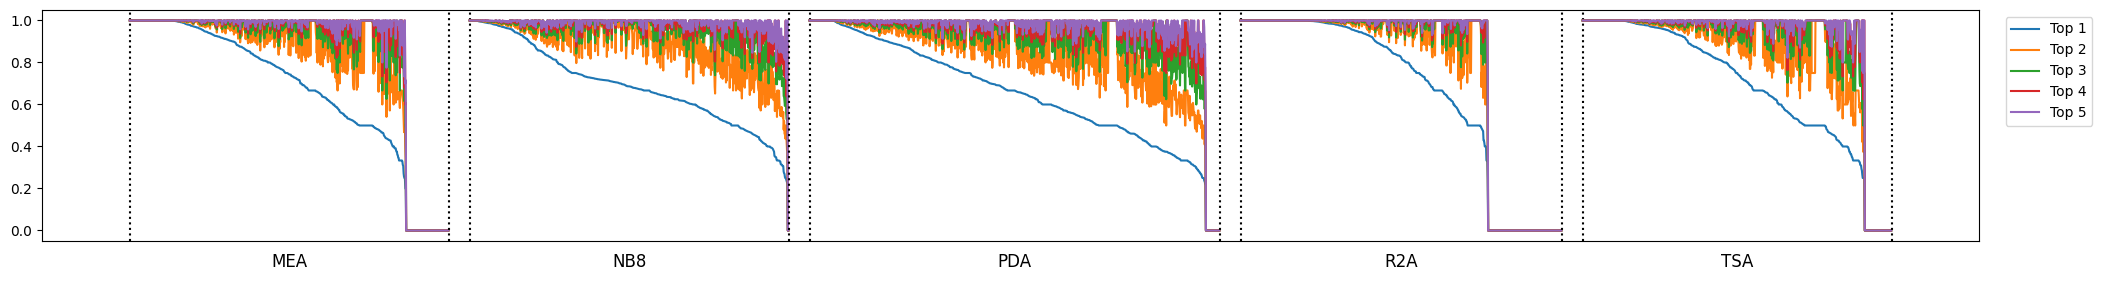

In [239]:
fig, ax = plt.subplots(figsize=(25, 3))
start_x = 0
x_in_between = 50
uniq_medium_types = np.sort(np.unique(medium_types))
for i, medium_type in enumerate(uniq_medium_types):
    if medium_type == "unknown":
        continue
    df = top_taxa_df.T[np.array(medium_types) == medium_type]
    df.index = np.arange(len(df)) + start_x
    ax.axvline(start_x, linestyle="dotted", color="black")
    sns.lineplot(
        data=df,
        ax=ax,
        dashes=False,
        markers=False,
        legend=i == 0,
        # lw=0.5,
        # palette="tab10",
    )
    # add a dashed vertical line to separate medium types
    start_x += len(df)
    ax.axvline(start_x, linestyle="dotted", color="black")
    start_x += x_in_between
    # label medium type on x axis
    ax.text(
        start_x - len(df) / 2 - x_in_between,
        -0.15,
        medium_type,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=12,
    )
# no markers, no x axis tick labels or ticks
ax.set_xticks([])
ax.set_xticklabels([])
# put legend outside of plot
ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


In [139]:
top_taxa_df = top_taxa_df.T
top_taxa_df["medium_type"] = medium_types

In [23]:
def get_taxon_count(
    otu_count_df: pd.DataFrame, taxon_df: pd.DataFrame, taxon_level: str
) -> pd.DataFrame:
    if taxon_level == "otu":
        taxon_count_df = otu_count_df
    else:
        # aggregate taxon counts by taxon level from taxon_df
        taxon_count_df = (
            otu_count_df.merge(
                taxon_df[taxon_level].to_frame(), left_index=True, right_index=True
            )
            .groupby(taxon_level)
            .sum()
        )
    return taxon_count_df


def get_top_otu_df(
    otu_count_df: pd.DataFrame,
    taxon_df: pd.DataFrame,
    taxon_levels: str | list[str],
    top_k: int = 5,
) -> pd.DataFrame:
    taxon_levels = [taxon_levels] if isinstance(taxon_levels, str) else taxon_levels
    otu_abundance_df = otu_count_df.div(otu_count_df.sum(axis=0) + 1e-8, axis=1)
    taxon_df["otu"] = taxon_df.index
    otu_abundance_df = otu_abundance_df.merge(
        taxon_df[taxon_levels], left_index=True, right_index=True
    )
    taxa = otu_abundance_df[taxon_levels].to_numpy()
    otu_abundance_df = otu_abundance_df.drop(columns=taxon_levels)
    wells = otu_abundance_df.columns.to_numpy()
    top_otu_frac = []
    top_otu_taxa = [[] for _ in range(len(taxon_levels))]
    argmax_arr = np.argsort(otu_abundance_df, axis=0)
    max_arr = np.sort(otu_abundance_df, axis=0)
    for i in range(top_k):
        top_otu_frac.append(max_arr[-1 - i])
        # top_otu_taxon.append(taxa[argmax_arr[-1 - i]])
        for j in range(len(taxon_levels)):
            top_otu_taxa[j].append(taxa[argmax_arr[-1 - i]][:, j])
    return pd.concat(
        [
            pd.DataFrame(
                np.array(top_otu_taxa[j]).T,
                columns=[
                    "Top " + str(i) + " " + taxon_levels[j] for i in range(1, top_k + 1)
                ],
                index=wells,
            )
            for j in range(len(taxon_levels))
        ]
        + [
            pd.DataFrame(
                np.array(top_otu_frac).T,
                columns=["Top " + str(i) for i in range(1, top_k + 1)],
                index=wells,
            )
        ],
        axis=1,
    )

In [41]:
res_df = get_top_otu_df(otu_count_df, taxon_df, ["domain", "genus", "otu"]).merge(
    well_metadata_df, left_index=True, right_index=True
)

In [42]:
res_df

,Top 1 domain,Top 2 domain,Top 3 domain,Top 4 domain,Top 5 domain,Top 1 genus,Top 2 genus,Top 3 genus,Top 4 genus,Top 5 genus,...,Top 3 otu,Top 4 otu,Top 5 otu,Top 1,Top 2,Top 3,Top 4,Top 5,medium_type,fabric_type
FDM1AwA1,Fungi,Fungi,Fungi,Bacteria,Fungi,Penicillium,Penicillium,Penicillium,Escherichia/Shigella,Zymoseptoria,...,ITS-ZOTU10,16S-ZOTU5,ITS-ZOTU73,0.888060,0.074627,0.029851,0.007463,0.000000,MEA,5
FDM1AwB1,Fungi,Fungi,Bacteria,Fungi,Fungi,Penicillium,Penicillium,Arcticibacterium,Ascomycota_unidentified_1_1,Davidiella,...,16S-ZOTU21,ITS-ZOTU4,ITS-ZOTU75,0.902518,0.094248,0.003003,0.000231,0.000000,MEA,5
FDM1AwC1,Fungi,Fungi,Bacteria,Fungi,Bacteria,Penicillium,Exophiala,Escherichia/Shigella,Penicillium,Escherichia/Shigella,...,16S-ZOTU2,ITS-ZOTU7,16S-ZOTU5,0.433333,0.303125,0.141667,0.060417,0.059375,MEA,3
FDM1AwD1,Fungi,Fungi,Fungi,Fungi,Fungi,Penicillium,Penicillium,Penicillium,Penicillium,Rhodotorula,...,ITS-ZOTU7,ITS-ZOTU74,ITS-ZOTU84,0.857143,0.071429,0.071429,0.000000,0.000000,MEA,3
FDM1AwE1,Fungi,Fungi,Fungi,Bacteria,Fungi,Penicillium,Penicillium,Penicillium,Escherichia/Shigella,Ascomycota_unidentified_1_1,...,ITS-ZOTU10,16S-ZOTU2,ITS-ZOTU4,0.854701,0.119658,0.014245,0.005698,0.002849,MEA,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FTDT2AwL24,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Chryseobacterium,Microbacterium,Massilia,Dyella,Cohnella,...,16S-ZOTU3,16S-ZOTU4,16S-ZOTU13,0.333333,0.200000,0.133333,0.066667,0.066667,TSA,6
FTDT2AwM24,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteroides,Sporosarcina,Bacteroides,Bacteroides,Sporosarcina,...,16S-ZOTU48,16S-ZOTU44,16S-ZOTU81,0.265060,0.156627,0.156627,0.126506,0.054217,TSA,6
FTDT2AwN24,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Microbacterium,Chryseobacterium,Microbacterium,Cohnella,Cohnella,...,16S-ZOTU35,16S-ZOTU13,16S-ZOTU37,0.250000,0.125000,0.125000,0.125000,0.125000,TSA,6
FTDT2AwO24,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Massilia,Chryseobacterium,Microbacterium,Cohnella,Paraburkholderia,...,16S-ZOTU7,16S-ZOTU13,16S-ZOTU1,0.318182,0.250000,0.204545,0.090909,0.068182,unknown,u


In [43]:
res_df.to_excel("temp.xlsx")

In [55]:
res_df.query("`Top 1 genus` == 'Exophiala'")[
    ["medium_type", "fabric_type", "Top 1 otu", "Top 1 genus", "Top 1 domain", "Top 1"]
].query("`Top 1 otu` == 'ITS-ZOTU18'")

,medium_type,fabric_type,Top 1 otu,Top 1 genus,Top 1 domain,Top 1
FTDT1AwE9,TSA,5,ITS-ZOTU18,Exophiala,Fungi,0.641243


In [44]:
res_df.query("`Top 1` >= 0.8 and `Top 1 genus` == 'Exophiala'")[
    ["medium_type", "fabric_type", "Top 1 otu", "Top 1 genus", "Top 1 domain", "Top 1"]
].to_clipboard()

In [58]:
# filter for Bacteria, for each genus find the well with the highest purity (Top 1)
best_wells = (
    res_df.query("`Top 1 domain` == 'Bacteria'").groupby("Top 1 otu")["Top 1"].idxmax()
)
best_well_df = res_df.loc[best_wells][
    ["Top 1", "Top 1 otu", "Top 1 genus", "Top 1 domain", "medium_type", "fabric_type"]
]
temp_res_df = res_df.drop(best_wells)
sec_best_wells = (
    temp_res_df.query("`Top 1 domain` == 'Bacteria'")
    .groupby("Top 1 otu")["Top 1"]
    .idxmax()
)
sec_best_well_df = temp_res_df.loc[sec_best_wells][
    ["Top 1", "Top 1 otu", "Top 1 genus", "Top 1 domain", "medium_type", "fabric_type"]
]
pd.concat([best_well_df, sec_best_well_df]).sort_values("Top 1 otu").to_clipboard()

In [47]:
res_df.query(
    "`Top 1` >= 0.8 and `Top 1 domain` == 'Bacteria' and fabric_type != 'u'"
).groupby("Top 1 otu")["fabric_type"].nunique().sort_values().to_clipboard()

In [ ]:
genus_count_df = get_taxon_count(otu_count_df, taxon_df, "genus")
genus_count_df.div(genus_count_df.sum(axis=0) + 1e-8, axis=1)